# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [140]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re
from collections import Counter
from nltk import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import spacy
from spacy import displacy
from newsapi import NewsApiClient
from path import Path
import csv
nltk.download('vader_lexicon')
plt.style.use('seaborn-whitegrid')
mpl.rcParams['figure.figsize'] = [20.0, 10.0]
%matplotlib inline



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sameerlakhe/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [141]:
# Read your api key environment variable
load_dotenv()
api_key = os.getenv("NEWS_API_KEY")

In [153]:
# Function to create a dataframe for english news and french news
def create_df(news, language):
    articles = []
    for article in news:
        try:
            title = article["title"]
            description = article["description"]
            text = article["content"]
            date = article["publishedAt"][:10]

            articles.append({
                "title": title,
                "description": description,
                "text": text,
                "date": date,
                "language": language
            })
        except AttributeError:
            pass

    return pd.DataFrame(articles)

#this function writes the event data to a csv file to avoid calling the API multiple times
def write_csv(df,file_name):
    file_path = Path(file_name)
    df.to_csv(file_path, index=False, encoding='utf-8-sig')


# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)
#get the news using News Api client
def get_news(query,language,file_name,reload=False):
    complete_file_name = "./Resources/"+file_name
    path = Path(complete_file_name) 
    #if reload is specified as true, then do not read from old file
    if (path.exists() and reload == False):
        print(f'The file {complete_file_name} exists')
        news_df = pd.read_csv(complete_file_name)
    else:
        print(f'retreiving data from new API for query: {query}, and language:{language}')
        results = newsapi.get_everything(
                    q=query,
                    language=language
                )
        print(f'total results for query "{query}" in langyage:{language} are : {results["totalResults"]}')
        #convert the news articles to dataframe
        news_df = create_df(results["articles"], language)
        write_csv(news_df,complete_file_name)
    return news_df
    

In [154]:
bitcoin_news_en_df = get_news("bitcoin","en","Bitcoin_en.csv",False)
bitcoin_news_en_df.head()


The file ./Resources/Bitcoin_en.csv exists


,title,description,text,date,language
0,Miami’s Bitcoin Conference Left a Trail of Har...,"For some women, inappropriate conduct from oth...","Now, even though there are a number of women-f...",2022-05-10,en
1,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en
2,Warren Buffett Says He Wouldn't Take All the B...,Warren Buffett has always been a bitcoin skept...,Warren Buffett has always been a bitcoin skept...,2022-05-02,en
3,Luna Foundation Tried to Prop Up Terra’s Crumb...,"As a kid, I remember when my father tried to u...","As a kid, I remember when my father tried to u...",2022-05-16,en
4,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en


In [155]:
# Fetch the Ethereum news articles
ethereum_news_en_df = get_news("ethereum","en","Ethereum_en.csv",False)


The file ./Resources/Ethereum_en.csv exists


In [156]:
#dictionary to store the sentiment scores of the article
text_sent = {
        "text_compound": [],
        "text_pos": [],
        "text_neu": [],
        "text_neg": [],
        "text_sent": [],
        }

analyzer = SentimentIntensityAnalyzer()
# Get sentiment for the text and the title
def get_sentiment_score(news_df):
    
    for index, row in news_df.iterrows():
        try:
            # Sentiment scoring with VADER
            text_sentiment = analyzer.polarity_scores(row["text"])
            text_sent["text_compound"].append(text_sentiment["compound"])
            text_sent["text_pos"].append(text_sentiment["pos"])
            text_sent["text_neu"].append(text_sentiment["neu"])
            text_sent["text_neg"].append(text_sentiment["neg"])
            text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
        except AttributeError:
            pass
        
    return text_sent

text_sent = get_sentiment_score(bitcoin_news_en_df)
    
# Attaching sentiment columns to the News DataFrame
bitcoin_text_sentiment_df = pd.DataFrame(text_sent)
bitcoin_news_en_df = bitcoin_news_en_df.join(bitcoin_text_sentiment_df)
bitcoin_news_en_df.head()

,title,description,text,date,language,text_compound,text_pos,text_neu,text_neg,text_sent
0,Miami’s Bitcoin Conference Left a Trail of Har...,"For some women, inappropriate conduct from oth...","Now, even though there are a number of women-f...",2022-05-10,en,0.0772,0.036,0.964,0.000,1
1,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en,-0.0516,0.056,0.882,0.061,-1
2,Warren Buffett Says He Wouldn't Take All the B...,Warren Buffett has always been a bitcoin skept...,Warren Buffett has always been a bitcoin skept...,2022-05-02,en,-0.3269,0.085,0.772,0.143,-1
3,Luna Foundation Tried to Prop Up Terra’s Crumb...,"As a kid, I remember when my father tried to u...","As a kid, I remember when my father tried to u...",2022-05-16,en,0.3818,0.114,0.833,0.052,1
4,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en,0.3400,0.072,0.928,0.000,1


In [157]:
# Create the Ethereum sentiment scores DataFrame
text_sent = get_sentiment_score(ethereum_news_en_df)
    
# Attaching sentiment columns to the News DataFrame
ethereum_text_sentiment_df = pd.DataFrame(text_sent)
ethereum_news_en_df = ethereum_news_en_df.join(ethereum_text_sentiment_df)
ethereum_news_en_df.head()


,title,description,text,date,language,text_compound,text_pos,text_neu,text_neg,text_sent
0,Here's what NFTs look like on Instagram,Meta has revealed more of how NFTs will work o...,Meta has revealed more of how NFTs will work o...,2022-05-10,en,0.0772,0.036,0.964,0.000,1
1,Yuga Labs apologises after sale of virtual lan...,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02,en,-0.0516,0.056,0.882,0.061,-1
2,How Bored Ape Yacht Club Broke Ethereum - CNET,"Transactions stalled for hours, and people pai...",When Bored Ape Yacht Club creators Yuga Labs a...,2022-05-04,en,-0.3269,0.085,0.772,0.143,-1
3,Cryptoverse: Ether prepares for epic 'merge' i...,Ether has promised to do better. It has promis...,April 26 (Reuters) - Ether has promised to do ...,2022-04-26,en,0.3818,0.114,0.833,0.052,1
4,What is the Ethereum merge and how could it ma...,Ethereum is preparing for an upgrade that’s be...,Ethereum is preparing for an upgrade thats bee...,2022-04-26,en,0.3400,0.072,0.928,0.000,1


In [149]:
bitcoin_text_sentiment_df.describe()

,text_compound,text_pos,text_neu,text_neg,text_sent
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.050425,0.056750,0.877950,0.065250,-0.150000
std,0.345791,0.063839,0.095944,0.058037,0.988087
min,-0.549900,0.000000,0.557000,0.000000,-1.000000
25%,-0.335475,0.000000,0.849500,0.037500,-1.000000
50%,-0.114750,0.042000,0.894000,0.062000,-1.000000
75%,0.152575,0.085000,0.937000,0.077000,1.000000
max,0.750600,0.202000,1.000000,0.241000,1.000000


In [150]:
ethereum_text_sentiment_df.describe()

,text_compound,text_pos,text_neu,text_neg,text_sent
count,40.000000,40.000000,40.000000,40.000000,40.000000
mean,-0.032100,0.054675,0.888975,0.056375,-0.200000
std,0.386095,0.069201,0.080990,0.052014,0.966092
min,-0.690800,0.000000,0.557000,0.000000,-1.000000
25%,-0.320375,0.000000,0.857250,0.000000,-1.000000
50%,-0.165500,0.039000,0.923000,0.062000,-1.000000
75%,0.237625,0.078250,0.937000,0.075500,1.000000
max,0.865500,0.269000,1.000000,0.241000,1.000000


### Questions:

Q: Which coin had the highest mean positive score?

A: ***Both coins have same mean positive score of 0.054675***

Q: Which coin had the highest compound score?

A: ***Ethereum has the highest compound score of 0.865500***

Q. Which coin had the highest positive score?

A: ***Ethereum has the highest positive score of 0.269000***


---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [158]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = set(stopwords.words('english'))

In [159]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    # Convert the words to lowercase
    # Remove the stop words
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    return tokens

big_string = ' '.join(bitcoin_news_en_df["text"][0])
#print(big_string)

tokens = tokenizer(big_string)
print(tokens)

['n', 'w', 'e', 'v', 'e', 'n', 'h', 'u', 'g', 'h', 'h', 'e', 'r', 'e', 'r', 'e', 'n', 'u', 'b', 'e', 'r', 'f', 'w', 'e', 'n', 'f', 'c', 'u', 'e', 'c', 'r', 'p', 'p', 'c', 'e', 'e', 'n', 'r', 'n', 'w', 'e', 'n', 'r', 'e', 'l', 'l', 'u', 'n', 'e', 'r', 'r', 'e', 'p', 'r', 'e', 'e', 'n', 'e', 'v', 'e', 'b', 'e', 'e', 'n', 'n', 'p', 'c', 'e', 'w', 'h', 'e', 'r', 'e', 'h', 'e', 'n', 'l', 'b', 'l', 'c', 'k', 'p', 'e', 'r', 'n', 'r', 'h', 'e', 'n', 'l', 'w', 'n', 'r', 'h', 'e', 'n', 'l', 'b', 'c', 'h', 'r']


In [14]:
# Create a new tokens column for Bitcoin
def generate_tokens(df):
    list_tokens=[]
    for row in df["text"]:
        tokens = tokenizer(row)
        list_tokens.append(tokens)
    return list_tokens

bitcoin_tokens = generate_tokens(bitcoin_news_all_df)
bitcoin_news_all_df['tokens'] = bitcoin_tokens
bitcoin_news_all_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,Why fossil fuel companies see green in Bitcoin...,ExxonMobil and other fossil fuel companies hav...,A Bitcoin mining site powered by otherwise los...,2022-05-04,en,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[bitcoin, mining, site, powered, otherwise, lo..."
0,The Problem with Bitcoin Miners,Comments,Disclosure: I hold short positions in companie...,2022-05-15,fr,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[disclosure, hold, short, position, company, m..."
1,What is Blockchain: Everything You Need to Kno...,<table><tr><td></td></tr><tr><td></td></tr>\r\...,"If you want to pay online, you need to registe...",2022-04-18,en,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[want, pay, online, need, register, account, p..."
1,"L’âge d’or du cinéma n’est plus, place à l’âge...",L’une des plus grandes chaînes de salles de ci...,"AMC peut remercier les boursicoteurs, qui lui ...",2022-04-19,fr,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[amc, peut, remercier, boursicoteurs, permis, ..."
2,Bitcoin value drops by 50% since November peak,The slide in the value of cryptocurrencies com...,"Image source, Getty Images\r\nThe value of Bit...",2022-05-09,en,0.34,0.255,0.745,0.0,1,0.3400,0.072,0.928,0.000,1,"[image, source, getty, imagesthe, value, bitco..."


In [15]:
# Create a new tokens column for Ethereum
ethereum_tokens = generate_tokens(ethereum_news_all_df)
ethereum_news_all_df['tokens'] = ethereum_tokens
ethereum_news_all_df.head()

,title,description,text,date,language,title_compound,title_pos,title_neu,title_neg,title_sent,text_compound,text_pos,text_neu,text_neg,text_sent,tokens
0,What is Blockchain: Everything You Need to Kno...,<table><tr><td></td></tr><tr><td></td></tr>\r\...,"If you want to pay online, you need to registe...",2022-04-18,en,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[want, pay, online, need, register, account, p..."
0,"L’âge d’or du cinéma n’est plus, place à l’âge...",L’une des plus grandes chaînes de salles de ci...,"AMC peut remercier les boursicoteurs, qui lui ...",2022-04-19,fr,0.00,0.000,1.000,0.0,0,-0.0516,0.056,0.882,0.061,-1,"[amc, peut, remercier, boursicoteurs, permis, ..."
1,How Bored Ape Yacht Club Broke Ethereum - CNET,"Transactions stalled for hours, and people pai...",When Bored Ape Yacht Club creators Yuga Labs a...,2022-05-04,en,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[bored, ape, yacht, club, creator, yuga, labs,..."
1,"Ne vous tatouez pas votre crypto préférée, vou...",Ce milliardaire américain a eu la mauvaise idé...,Mike Novogratz est l’une des figures emblémati...,2022-05-15,fr,0.00,0.000,1.000,0.0,0,0.5719,0.157,0.775,0.068,1,"[mike, novogratz, lune, figure, emblmatiques, ..."
2,Yuga Labs apologises after sale of virtual lan...,Demand for plots of land in multiplayer game O...,A multi-billion dollar cryptocurrency company ...,2022-05-02,en,0.34,0.255,0.745,0.0,1,0.3400,0.072,0.928,0.000,1,"[multibillion, dollar, cryptocurrency, company..."


---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [16]:
def get_big_token_string(df):
    big_str=''
    for row in df["tokens"]:
        list_string = ' '.join(row)
        big_str = big_str + list_string
    return big_str



In [17]:
# Generate the Bitcoin N-grams where N=2
bitcoin_token_string_all_news = get_big_token_string(bitcoin_news_all_df)
#print(bitcoin_token_string_all_news)
bitcoin_tokens_all_news = bitcoin_token_string_all_news.split()
bitcoin_bigram_counts = Counter(ngrams(bitcoin_tokens_all_news, n=2))
#print(bigram_counts)
print(dict(bitcoin_bigram_counts))






{('bitcoin', 'mining'): 3, ('mining', 'site'): 1, ('site', 'powered'): 1, ('powered', 'otherwise'): 1, ('otherwise', 'lost'): 1, ('lost', 'gas'): 1, ('gas', 'oil'): 1, ('oil', 'well'): 1, ('well', 'near'): 1, ('near', 'linden'): 1, ('linden', 'texas'): 1, ('texas', 'april'): 1, ('april', 'th'): 1, ('th', 'photo'): 1, ('photo', 'francois'): 1, ('francois', 'picardafp'): 1, ('picardafp', 'via'): 1, ('via', 'getty'): 1, ('getty', 'images'): 1, ('images', 'corporate'): 1, ('corporate', 'climate'): 1, ('climate', 'hype'): 1, ('hype', 'fl'): 1, ('fl', 'chardisclosure'): 1, ('chardisclosure', 'hold'): 1, ('hold', 'short'): 1, ('short', 'position'): 1, ('position', 'company'): 1, ('company', 'mentioned'): 1, ('mentioned', 'article'): 1, ('article', 'financial'): 1, ('financial', 'advicesix'): 1, ('advicesix', 'month'): 1, ('month', 'ago'): 1, ('ago', 'wrotebitcoin'): 1, ('wrotebitcoin', 'miner'): 1, ('miner', 'burn'): 1, ('burn', 'enormous'): 1, ('enormous', 'amount'): 1, ('amount', 'capital')

In [18]:
# Generate the Ethereum N-grams where N=2
ethereum_token_string_all_news = get_big_token_string(ethereum_news_all_df)
#print(ethereum_token_string_all_news)
ethereum_tokens_all_news = ethereum_token_string_all_news.split()
ethereum_bigram_counts = Counter(ngrams(ethereum_tokens_all_news, n=2))
print(dict(ethereum_bigram_counts))

{('want', 'pay'): 1, ('pay', 'online'): 1, ('online', 'need'): 1, ('need', 'register'): 1, ('register', 'account'): 1, ('account', 'provide'): 1, ('provide', 'credit'): 1, ('credit', 'card'): 2, ('card', 'information'): 1, ('information', 'dont'): 1, ('dont', 'credit'): 1, ('card', 'pay'): 1, ('pay', 'bank'): 1, ('bank', 'transfer'): 1, ('transfer', 'rise'): 1, ('rise', 'cryptocurrencies'): 1, ('cryptocurrencies', 'charamc'): 1, ('charamc', 'peut'): 1, ('peut', 'remercier'): 1, ('remercier', 'boursicoteurs'): 1, ('boursicoteurs', 'permis'): 1, ('permis', 'voir'): 1, ('voir', 'cours'): 1, ('cours', 'senvoler'): 1, ('senvoler', 'bourse'): 1, ('bourse', 'depuis'): 1, ('depuis', 'plus'): 1, ('plus', 'dun'): 1, ('dun', 'grce'): 1, ('grce', 'phnomne'): 1, ('phnomne', 'gamestop'): 1, ('gamestop', 'wallstreetbets'): 1, ('wallstreetbets', 'reddit'): 1, ('reddit', 'lre'): 1, ('lre', 'meme'): 1, ('meme', 'stock'): 1, ('stock', 'charbored'): 1, ('charbored', 'ape'): 1, ('ape', 'yacht'): 1, ('yacht

In [19]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [20]:
# Use token_count to get the top 10 words for Bitcoin
bitcoin_top_words = token_count(bitcoin_tokens_all_news,10)
print(bitcoin_top_words)

[('bitcoin', 16), ('plus', 7), ('cryptocurrency', 5), ('crypto', 5), ('may', 5), ('cryptomonnaie', 5), ('dollar', 5), ('reuters', 4), ('gain', 4), ('blockchain', 4)]


In [21]:
# Use token_count to get the top 10 words for Ethereum
ethereum_top_words = token_count(ethereum_tokens_all_news,10)
print(ethereum_top_words)

[('nft', 9), ('ha', 7), ('cryptocurrency', 5), ('world', 5), ('plus', 4), ('crypto', 4), ('web', 4), ('one', 4), ('want', 3), ('pay', 3)]


---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

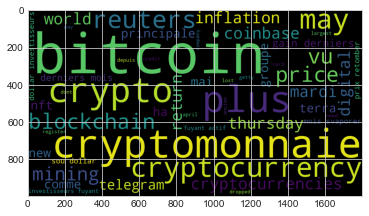

In [22]:
# Generate the Bitcoin word cloud
wc_bitcoin = WordCloud(width=1800, height=1000, max_words=50).generate(bitcoin_token_string_all_news)
plt.imshow(wc_bitcoin)



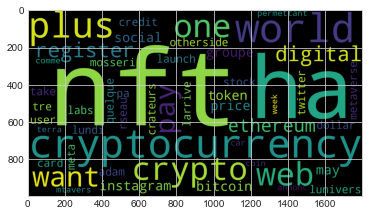

In [23]:
# Generate the Ethereum word cloud
wc_ethereum = WordCloud(width=1800, height=1000, max_words=50).generate(ethereum_token_string_all_news)
plt.imshow(wc_ethereum)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [24]:
def get_big_token_string(df):
    big_str=''
    for row in df["tokens"]:
        list_string = ' '.join(row)
        big_str = big_str + list_string
    return big_str

In [25]:
# Download the language model for SpaCy
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.8 MB 2.4 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [26]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [27]:
# Concatenate all of the Bitcoin text together
def get_all_news_data(df):
    big_str=''
    for row in df["text"]:
        list_string = ' '.join(row)
        big_str = big_str + list_string
    return big_str

In [28]:
# Run the NER processor on all of the text
# Set article to be analyzed with spaCy
bitcoin_all_en_news_data = get_all_news_data(bitcoin_news_en_df)
doc = nlp(bitcoin_all_en_news_data)

# Add a title to the document
# YOUR CODE HERE!

In [29]:
# Render NER visualization with displacy
displacy.render(doc, style='ent')

In [30]:
# List all Entities
print([ent.text for ent in doc.ents])

['o w e r e d   ', 'i s e   l', '2 2', 'a g e s', '+ 6 5', '4 4', 'u   w', 'u', 'n', 's f e', 'i s e', '+ 8 8 3 6   ', 'a g e   s', 'u r c e', 'a g e s', 'n u e d', 'w e e k e n d', '6 3 0', 'a s e', 'g e s', 'g e s t   ', 'i n s', 'u g h   c', 'u r s d a y', '2 1', 'n f', 'f f e r   ', 'u r e', '8 1', 'n f', 'f f e r   ', 'u r e', '8 1', 'n d e', 'a k e', 'o r e', 'i o n s .', 'u s   ', 'i s s', 'i o n .', '+ 6 0', '2 2', 'r s e y', 'u r s d', 'o s s', 'f t e n e d   ', '+ 6 3 5', 'i n s   ', '6 4', '2 2', '1 9', '9 4', 'a s e   G', 'w h e', 'o r e', 'u s', 'e r s', 'u m e s', '+ 1 7 2 6   ', '2 0 2 2', 'l s e', 'u', 'u   s', 'a d e d', '3', '2 2', 'u s', 'e r s', '2 2', 'u n', 'a k e   ', '5 0 %', 'u r s d a y', '+ 2 2', '9', "F e d ' s", '1 4', 'u s h i', 'f e w   ', 'n f', 'u s   M e', 'g', 'u g h   w e e k', '6 3', 'u', 's e e', '3 0 %', 'w e e k - o n - w e e k', 't   s e e n   s i n c e   2 0 2 0', 'i n s   l i k e   s', '+ 8 2', '9 9', '1 6', 's t e r s', 'u r s d', '2', 'u   h

---

### Ethereum NER

In [31]:
# Concatenate all of the Ethereum text together
ethereum_all_en_news_data = get_all_news_data(ethereum_news_en_df)


In [32]:
# Run the NER processor on all of the text
doc = nlp(ethereum_all_en_news_data)

# Add a title to the document
# YOUR CODE HERE!

In [33]:
# Render the visualization
displacy.render(doc, style='ent')

In [34]:
# List all Entities
print([ent.text for ent in doc.ents])

['u   w', 'u', 'n', 's f e', 'i s e', '+ 8 8 3 6   ', 'u n c', 'u l d   l', 'u n c h', 'u n c h   e v e', '6 9', 'i s e', 'u s e r s', 'r s e   l a n d   ', 'f r e n z y', 'u g h t   ', 'g', 'a d e', 'n g l e', 'u l d', 'u r e', 'l d s', 'n d - l', 'g e s', '+ 2 8 2 4   ', 'n d e', 'a k e', 'o r e', 'i o n s .', 'u s   ', 'i s s', 'i o n .', '+ 6 0', '2 2', 'u s h i', 'f e w   ', 'n f', 'r s e y', 'n d e', 'i s i n f', '2 2', '1 9', 'a s e d   ', 'u   w', 'u l d   ', 'f e e', 'w e e k', 'f e e   s k', 'a g e   s', 'u r c e', 'a g e s', 'n u e d', 'w e e k e n d', '6 3 0', 'a s e', 'g e s', 'u p', 'u s i n e s s e s .', 'u s', 'a s e d   s m', 'f   s', '+ 8 8 1 6   ', 's h', 'g e n e', 'a s e d   ', 'u r e', 'n u e', 'f e e d', 'f r e', 'w n e r s h i', 'u s e r s', 'f e w   ', '+ 8 3 6 2', 'u s e', 'u r s e', 'u g h .', '2 0', 's e e n   ', 'n', 'k e n s', '1 1', 's e e m s', 'n', 'k e n s', 'g', 's s e t s', 'r e s e', 'g', 'n', 'q u e', '2 0', '2 2', 'o w e d   ', '+ 2 3 2 3   ', 'w 

---